In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [2]:

import numpy as np
from matplotlib import pyplot as plt
import nibabel as nib
from PIL import Image
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
import torchsummary
from torchvision import transforms
import time
from sklearn.metrics import classification_report

In [3]:
#파일이름 sort해서 list저장
data_path='/disk1/data_liverbound_noclip/'
name_list=os.listdir(data_path)

segmentation_data = [files[:-4] for files in name_list if files.startswith('segmentation')]
segmentation_data=list(set(segmentation_data))
segmentation_data.sort()
seg_data_test=[]
for i in range(30,45):
    seg_data_test.append(segmentation_data.pop(i))

volume_data=[files[:-4] for files in name_list if files.startswith('volume')]
volume_data=list(set(volume_data))
volume_data.sort()
vol_data_test=[]
for i in range(30,45):
    vol_data_test.append(volume_data.pop(i))

In [4]:
# all_labels=np.loadtxt('/home/sumins/workspace/liver_classification/all_labels.txt',dtype=int)
# all_labels=all_labels.tolist()

In [5]:
#npy를 slice별로 나누어 하나의 list저장
seg_list_train=[]
seg_list_test=[]
for file in segmentation_data:
    fname=os.path.basename(file)
    print(fname)
    img_array=np.load(data_path+fname+'.npy')
    
    #print(f'img_num: {img_array.shape}')
    
    if len(img_array.shape) == 3:
        nx, ny, nz = img_array.shape
        total_slices = img_array.shape[2]
        #print(total_slices)
        # iterate through slices
        for current_slice in range(0, total_slices):
            seg_list_train.append(img_array[:,:,current_slice]) 

for file in seg_data_test:
    fname=os.path.basename(file)
    print(fname)
    img_array=np.load(data_path+fname+'.npy')
    
    #print(f'img_num: {img_array.shape}')
    
    if len(img_array.shape) == 3:
        nx, ny, nz = img_array.shape
        total_slices = img_array.shape[2]
        print(total_slices)
        # iterate through slices
        for current_slice in range(0, total_slices):
            seg_list_test.append(img_array[:,:,current_slice]) 
#간 1, 병변 2, 나머지 0


vol_list_train=[]
vol_list_test=[]
for file in volume_data:
    fname=os.path.basename(file)
    print(fname)
    img_array=np.load(data_path+fname+'.npy')
    
    #print(f'img_num: {img_array.shape}')
    
    if len(img_array.shape) == 3:
        nx, ny, nz = img_array.shape
        total_slices = img_array.shape[2]
        # iterate through slices
        for current_slice in range(0, total_slices):
            vol_list_train.append(img_array[:,:,current_slice]) 
            
for file in vol_data_test:
    fname=os.path.basename(file)
    print(fname)
    img_array=np.load(data_path+fname+'.npy')
    
    #print(f'img_num: {img_array.shape}')
    
    if len(img_array.shape) == 3:
        nx, ny, nz = img_array.shape
        total_slices = img_array.shape[2]
        # iterate through slices
        for current_slice in range(0, total_slices):
            vol_list_test.append(img_array[:,:,current_slice]) 

segmentation-0
segmentation-1
segmentation-10
segmentation-100
segmentation-101
segmentation-102
segmentation-103
segmentation-104
segmentation-105
segmentation-106
segmentation-107
segmentation-108
segmentation-109
segmentation-11
segmentation-110
segmentation-111
segmentation-112
segmentation-113
segmentation-114
segmentation-115
segmentation-116
segmentation-117
segmentation-118
segmentation-119
segmentation-12
segmentation-120
segmentation-121
segmentation-122
segmentation-123
segmentation-124
segmentation-126
segmentation-128
segmentation-13
segmentation-15
segmentation-17
segmentation-19
segmentation-20
segmentation-22
segmentation-24
segmentation-26
segmentation-28
segmentation-3
segmentation-31
segmentation-33
segmentation-35
segmentation-36
segmentation-37
segmentation-38
segmentation-39
segmentation-4
segmentation-40
segmentation-41
segmentation-42
segmentation-43
segmentation-44
segmentation-45
segmentation-46
segmentation-47
segmentation-48
segmentation-49
segmentation-5
se

In [6]:
#label을 만들어 list에 저장
labels_train = []
labels_test=[]
for i in seg_list_test:
    if 2 in i:
        labels_test.append(1)
    else:
        labels_test.append(0)
        
for i in seg_list_train:
    if 2 in i:
        labels_train.append(1)
    else:
        labels_train.append(0)

In [7]:
def norm(nparray):
    # normalize scans to [0,1]
    _min = nparray.min()
    _max = nparray.max()
    nparray = nparray - _min
    nparray = nparray / (_max - _min)
    return nparray

def norm_zscore(nparray):
    # normalize 2d scands by mean and standard deviation
    mean = nparray.mean()
    std = nparray.std()    
    nparray = nparray - mean
    nparray /= std
    return nparray

In [8]:
WINDOW_MAX = 200
WINDOW_MIN = 0
GLOBAL_PIXEL_MEAN = 0.1

class CustomDataset(Dataset): 
  def __init__(self,volume_list,all_labels,transforms=None):
    self.volume_list=volume_list
    self.all_labels=all_labels
    self.length=len(all_labels)
    self.transforms=transforms


  def __len__(self):
    return self.length


  def __getitem__(self, idx):
    npy=self.volume_list[idx]

    npy[npy > WINDOW_MAX] = WINDOW_MAX
    npy[npy < WINDOW_MIN] = WINDOW_MIN
    
    npy = (npy - WINDOW_MIN) / (WINDOW_MAX - WINDOW_MIN)
    npy -= GLOBAL_PIXEL_MEAN
    
    if len(npy.shape)==2:
      npy=npy[:,:,np.newaxis].astype(dtype='float32')
    
    if self.transforms is not None:
      npy=self.transforms(npy)
    
    return{'npy':npy,'label':self.all_labels[idx]}

In [9]:
class CustomConvNet(nn.Module):
    def __init__(self):
        super(CustomConvNet, self).__init__() #상속받은 class에 접근하기 위함

        self.layer1 = self.conv_module(1, 16) #흑백사진은 inp
        self.layer2 = self.conv_module(16, 32)
        self.layer3 = self.conv_module(32, 64)
        self.layer4 = self.conv_module(64, 128)
        #self.layer5 = self.conv_module(128, 256)
        self.gap = self.global_avg_pool(128, 2)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
       # out = self.layer5(out)
        out = self.gap(out)
        out = out.view(-1, 2)

        return out

    def conv_module(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

    def global_avg_pool(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((1,1)))
        
model=CustomConvNet()
torchsummary.summary(model.cuda(),input_size=(1,512,512),batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 16, 512, 512]             160
       BatchNorm2d-2          [1, 16, 512, 512]              32
         LeakyReLU-3          [1, 16, 512, 512]               0
         MaxPool2d-4          [1, 16, 256, 256]               0
            Conv2d-5          [1, 32, 256, 256]           4,640
       BatchNorm2d-6          [1, 32, 256, 256]              64
         LeakyReLU-7          [1, 32, 256, 256]               0
         MaxPool2d-8          [1, 32, 128, 128]               0
            Conv2d-9          [1, 64, 128, 128]          18,496
      BatchNorm2d-10          [1, 64, 128, 128]             128
        LeakyReLU-11          [1, 64, 128, 128]               0
        MaxPool2d-12            [1, 64, 64, 64]               0
           Conv2d-13           [1, 128, 64, 64]          73,856
      BatchNorm2d-14           [1, 128,

In [10]:
transforms_train = transforms.Compose([transforms.ToTensor()
                                       ])
transforms_test = transforms.Compose([transforms.ToTensor()
                                       ])

hyper_param_epoch=100
hyper_param_batch=32
hyper_param_learning_rate=0.00001

In [11]:
#vol_train, vol_valid, lab_train, lab_valid = train_test_split(volume_list, all_labels, test_size=0.3, shuffle=True, stratify=all_labels, random_state=34)
train_dataset=CustomDataset(volume_list=vol_list_train, all_labels=labels_train,transforms=transforms_train)
test_dataset=CustomDataset(volume_list=vol_list_test,all_labels=labels_test,transforms=transforms_test)
train_loader = DataLoader(train_dataset, batch_size=hyper_param_batch, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=hyper_param_batch, shuffle=True)

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device,"/" ,torch.cuda.device_count())

custom_model=CustomConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_model.parameters(), lr=hyper_param_learning_rate)

cuda:0 / 1


In [13]:
def validation_loss(model):
    total_loss=0
    for i_batch, item in enumerate(test_loader):
        npys = item['npy'].to(device)
        labels = item['label'].to(device)
 
        outputs =model(npys)
        loss = criterion(outputs, labels)

        total_loss+=loss.item()
    return total_loss/(i_batch+1)

In [14]:
loss_value=1
start=time.time()
custom_model.train()
train_loss_history=[]
valid_loss_history=[]
for e in range(hyper_param_epoch):
        for i_batch, item in enumerate(train_loader):
                npys = item['npy'].to(device)
                labels = item['label'].to(device)
                #print(npys)
                # Forward pass
                outputs =custom_model(npys)
                loss = criterion(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        val_loss=validation_loss(custom_model)
        train_loss_history.append(loss.item())
        valid_loss_history.append(val_loss)
        print('Epoch [{}/{}],i_batch={} ,Train_Loss: {:.4f},Valid_loss: {:.4f}'
                                        .format(e + 1, hyper_param_epoch, i_batch+1, loss.item(),val_loss))
        print("Time: {}sec".format(time.time()-start))
        start=time.time()
        if loss_value>val_loss:
                loss_value=val_loss
                torch.save({
                'epoch': e,
                'model_state_dict': custom_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, '/home/sumins/workspace/model_check/model_re3.pth')


Epoch [1/100],i_batch=604 ,Train_Loss: 0.6592,Valid_loss: 0.6174
Time: 119.45671916007996sec
Epoch [2/100],i_batch=604 ,Train_Loss: 0.6234,Valid_loss: 0.6114
Time: 97.1126618385315sec
Epoch [3/100],i_batch=604 ,Train_Loss: 0.6475,Valid_loss: 0.6089
Time: 95.61546874046326sec
Epoch [4/100],i_batch=604 ,Train_Loss: 0.6437,Valid_loss: 0.6061
Time: 95.84314560890198sec
Epoch [5/100],i_batch=604 ,Train_Loss: 0.5975,Valid_loss: 0.6080
Time: 95.60302066802979sec
Epoch [6/100],i_batch=604 ,Train_Loss: 0.6512,Valid_loss: 0.6074
Time: 76.92167615890503sec
Epoch [7/100],i_batch=604 ,Train_Loss: 0.6431,Valid_loss: 0.6061
Time: 74.05818819999695sec
Epoch [8/100],i_batch=604 ,Train_Loss: 0.5912,Valid_loss: 0.6020
Time: 74.41696572303772sec
Epoch [9/100],i_batch=604 ,Train_Loss: 0.5647,Valid_loss: 0.6032
Time: 74.3436529636383sec
Epoch [10/100],i_batch=604 ,Train_Loss: 0.5910,Valid_loss: 0.5995
Time: 74.23176574707031sec
Epoch [11/100],i_batch=604 ,Train_Loss: 0.6579,Valid_loss: 0.6028
Time: 76.74722

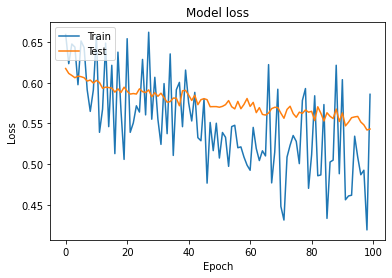

In [18]:
plt.plot(train_loss_history)
plt.plot(valid_loss_history)
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
import csv


with open("valid_loss_history4.csv", 'w') as file:
  writer = csv.writer(file)
  writer.writerow(valid_loss_history)


In [20]:
import csv


with open("train_loss_history4.csv", 'w') as file:
  writer = csv.writer(file)
  writer.writerow(train_loss_history)


In [21]:
true_label=[]
pred_label=[]

model=CustomConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_param_learning_rate)

checkpoint = torch.load('/home/sumins/workspace/model_check/model_re3.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(loss)
custom_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for item in test_loader:
        npys = item['npy'].to(device)
        labels = item['label'].to(device)
        
        outputs =model(npys)
        _, predicted = torch.max(outputs.data, 1)
        true_label.extend(labels)
        pred_label.extend(predicted)
        total += len(labels)
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy of the model on the {} test images: {} %'.format(total, 100 * correct / total))

tensor(0.4190, device='cuda:0', requires_grad=True)
Test Accuracy of the model on the 2897 test images: 77.04521919226787 %


: 

In [51]:
true_labels=torch.tensor(true_label)
true_labels=true_labels.tolist()
pred_labels=torch.tensor(pred_label)
pred_labels=pred_labels.tolist()
print(classification_report(true_labels,pred_labels))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      2155
           1       0.54      0.42      0.47       742

    accuracy                           0.76      2897
   macro avg       0.68      0.65      0.66      2897
weighted avg       0.74      0.76      0.75      2897



In [48]:
true_label1=[]
pred_label1=[]

model=CustomConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_param_learning_rate)

checkpoint = torch.load('/home/sumins/workspace/model_check/model_val.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(loss)
custom_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for item in train_loader:
        npys = item['npy'].to(device)
        labels = item['label'].to(device)
        
        outputs =model(npys)
        _, predicted = torch.max(outputs.data, 1)
        true_label1.extend(labels)
        pred_label1.extend(predicted)
        total += len(labels)
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy of the model on the {} train images: {} %'.format(total, 100 * correct / total))

tensor(0.0885, device='cuda:0', requires_grad=True)
Test Accuracy of the model on the 19310 train images: 99.99482133609528 %


In [49]:
true_labels1=torch.tensor(true_label1)
true_labels1=true_labels1.tolist()
pred_labels1=torch.tensor(pred_label1)
pred_labels1=pred_labels1.tolist()
print(classification_report(true_labels1,pred_labels1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13062
           1       1.00      1.00      1.00      6248

    accuracy                           1.00     19310
   macro avg       1.00      1.00      1.00     19310
weighted avg       1.00      1.00      1.00     19310

